# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **Keras** (version $\ge$ 2 required). 


In [2]:
#!pip install tensorflow, keras
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/yujiaze/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/yujiaze/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/yujiaze/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libnvidia-fatbinaryloader.so.396.54: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

If we are using TensorFlow as the backend, we can check whether we have GPUs available:

## MNIST data set

Next we'll load the MNIST handwritten digits data set.  First time we may have to download the data, which can take a while.


In [2]:
from keras.datasets import mnist

## MNIST:
(X_train, y_train), (X_test, y_test) = ...

nb_classes = ...

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = ...
Y_test = ...

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. `y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample, and `Y_train` is a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding of `y_train`.

Let's take a closer look. Here are the first 10 training digits (or fashion items for Fashion-MNIST):

Training sample 0 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Training sample 1 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 2 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Training sample 3 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 4 : class: 9 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Training sample 5 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 6 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 7 : class: 3 , one-hot encoded: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training sample 8 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 9 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


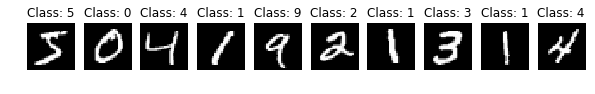

In [3]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:], cmap="gray")
    plt.title('Class: '+str(y_train[i]))
    print('Training sample',i,': class:',y_train[i], ', one-hot encoded:', Y_train[i])

## Linear model

### Initialization

Let's begin with a simple linear model.  We first initialize the model with `Sequential()`.  Then we add a `Dense` layer that has 28*28=784 input nodes (one for each pixel in the input image) and 10 output nodes. The `Dense` layer connects each input to each output with some weight parameter. 

Finally, we select *categorical crossentropy* as the loss function, select [*stochastic gradient descent*](https://keras.io/optimizers/#sgd) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model. Note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *sgd*.

In [4]:
linmodel = ...
linmodel.add(...)

linmodel.compile(...)
print(linmodel.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


The summary shows that there are 7850 parameters in our model, as the weight matrix is of size 785x10 (not 784, as there's an additional bias term).

### Learning

Now we are ready to train our first model.  An *epoch* means one pass through the whole training data. 

The `reshape()` function flattens our 28x28 images into vectors of length 784.  (This means we are not using any information about the spatial neighborhood relations of pixels.  This setup is known as the *permutation invariant MNIST*.)  

You can run code below multiple times and it will continue the training process from where it left off.  If you want to start from scratch, re-initialize the model using the code a few cells ago. 

In [6]:
%%time
epochs = 10 # one epoch takes about 3 seconds

linhistory = 

Epoch 1/10
 - 132s - loss: 0.7826 - acc: 0.8147
Epoch 2/10
 - 3s - loss: 0.4563 - acc: 0.8808
Epoch 3/10
 - 3s - loss: 0.4035 - acc: 0.8908
Epoch 4/10
 - 3s - loss: 0.3772 - acc: 0.8967
Epoch 5/10
 - 3s - loss: 0.3605 - acc: 0.9008
Epoch 6/10
 - 3s - loss: 0.3487 - acc: 0.9036
Epoch 7/10
 - 3s - loss: 0.3397 - acc: 0.9055
Epoch 8/10
 - 3s - loss: 0.3326 - acc: 0.9075
Epoch 9/10
 - 3s - loss: 0.3268 - acc: 0.9087
Epoch 10/10
 - 3s - loss: 0.3218 - acc: 0.9103
CPU times: user 3min 8s, sys: 7.91 s, total: 3min 16s
Wall time: 2min 36s


Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data.  It gives some indication of the real accuracy of the model but cannot be fully trusted, as it may have overfitted and just memorizes the training data.

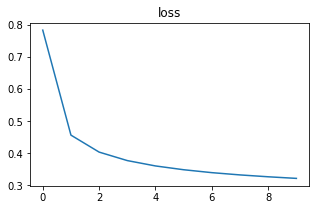

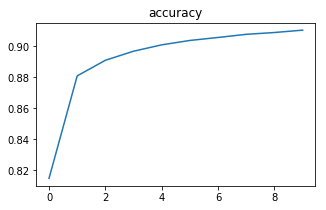

In [7]:
plt.figure(figsize=(5,3))
plt.plot(linhistory.epoch,linhistory.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(linhistory.epoch,linhistory.history['acc'])
plt.title('accuracy');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [8]:
linscores = 
print("%s: %.2f%%" % (linmodel.metrics_names[1], linscores[1]*100))

acc: 91.60%


We can now take a closer look on the results.

Let's define a helper function to show the failure cases of our classifier. 

In [9]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(X_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test digits the linear model classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


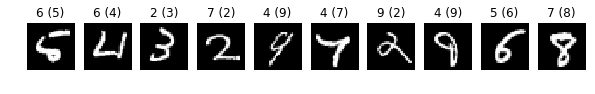

In [10]:
linpredictions = ...

show_failures(linpredictions)

## Multi-layer perceptron (MLP) network

### Activation functions

Let's start by plotting some common activation functions for neural networks. `'relu'` stands for rectified linear unit, $y=\max(0,x)$, a very simple non-linearity we will be using in our MLP network below.

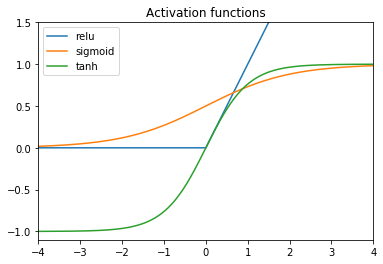

In [11]:
x = np.arange(-4,4,.01)
plt.figure()
plt.plot(x, np.maximum(x,0), label='relu')
plt.plot(x, 1/(1+np.exp(-x)), label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.axis([-4, 4, -1.1, 1.5])
plt.title('Activation functions')
plt.legend(loc='best');

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers.  `Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

There are two options below, a simple and a bit more complex model.  Select either one.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the groundtruth (`Y_train`). 

Finally, we again `compile()` the model, this time using [*Adam*](https://keras.io/optimizers/#adam) as the optimizer.

In [12]:
# Model initialization:
model = ...

# A simple model:
model.add(...)
model.add(...)

# A bit more complex model:
#model.add(Dense(units=50, input_dim=28*28))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

#model.add(Dense(units=50))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

# The last layer needs to be like this:
model.add(...)

model.compile(...)
print(...)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                15700     
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


### Learning

In [14]:
%%time
epochs = 10 # one epoch with simple model takes about 4 seconds

history = ...

Epoch 1/10
 - 3s - loss: 0.4034 - acc: 0.8862
Epoch 2/10
 - 3s - loss: 0.2288 - acc: 0.9342
Epoch 3/10
 - 3s - loss: 0.1886 - acc: 0.9454
Epoch 4/10
 - 3s - loss: 0.1629 - acc: 0.9531
Epoch 5/10
 - 3s - loss: 0.1452 - acc: 0.9582
Epoch 6/10
 - 3s - loss: 0.1325 - acc: 0.9607
Epoch 7/10
 - 4s - loss: 0.1243 - acc: 0.9633
Epoch 8/10
 - 3s - loss: 0.1164 - acc: 0.9659
Epoch 9/10
 - 3s - loss: 0.1106 - acc: 0.9669
Epoch 10/10
 - 4s - loss: 0.1052 - acc: 0.9688
CPU times: user 1min 9s, sys: 6.53 s, total: 1min 15s
Wall time: 34.3 s


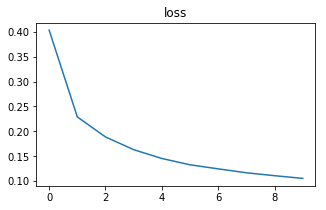

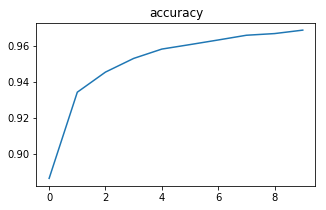

In [15]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

### Inference

Accuracy for test data.  The model should be somewhat better than the linear model. 

In [16]:
%%time
scores = ...
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 96.11%
CPU times: user 385 ms, sys: 31.3 ms, total: 416 ms
Wall time: 212 ms


We can again take a closer look on the results, using the `show_failures()` function defined earlier.

Here are the first 10 test digits the MLP classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


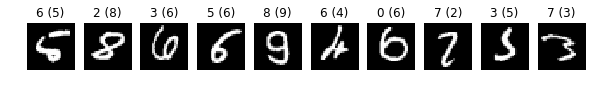

In [17]:
predictions = ...

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


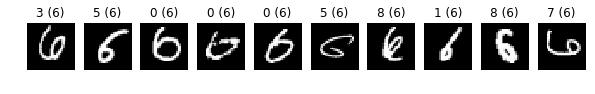

In [18]:
show_failures(predictions, trueclass=6)

We can also compute the confusion matrix to see which digits get mixed the most, and look at classification accuracies separately for each class:

Confusion matrix (rows: true classes; columns: predicted classes):

Classification accuracy for each class:

0: 0.9847
1: 0.9859
2: 0.9632
3: 0.9465
4: 0.9582
5: 0.9462
6: 0.9624
7: 0.9601
8: 0.9394
9: 0.9594


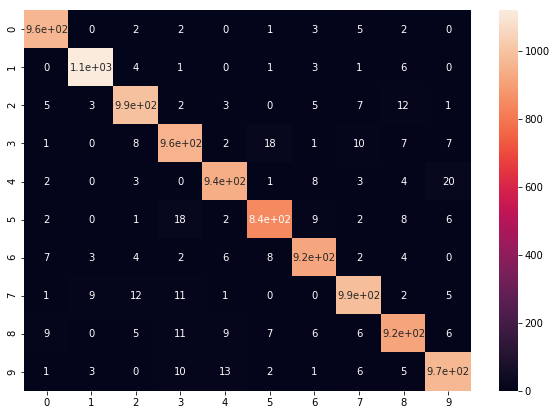

In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the Keras documentation at https://keras.io/.  For example, the Dense, Activation, and Dropout layers are described at https://keras.io/layers/core/.

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-mnist-mlp.ipynb).*